# Mission - Classifiez automatiquement des informations

Vous êtes mandaté en tant que Consultant Data Scientist par le département RH de votre client. Il s’agit de l'ESN TechNova Partners, spécialisée dans le conseil en transformation digitale et la vente d’applications en SaaS.
 
Ils font face à un turnover plus élevé que d'habitude et ils souhaitent identifier les causes racines potentielles derrière ces démissions.

### Importation des librairies

In [12]:
# Librairies "classiques"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from IPython.display import Image, display

# Librairies scikit-learn
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
# Preprocess et modèles
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

# Fonctions python créées
from utils import prepare_xy
from utils import scaler_ou_non
from utils import modelisation

### On reprend les éléments du premier notebook

In [13]:
donnees_modelisation = pd.read_csv("../Data/Processed/Projet_4_etape1_clean.csv")

# Partie 3 - Réalisation d'un premier modèle de classification

### Recommandations de l'étape 3 :
* Commencer par réaliser une séparation train test simple ou une validation croisée simple.

* Commencer par entraîner d’abord un modèle Dummy, puis un modèle linéaire, avant d'entraîner un modèle non-linéaire. Cela vous permettra d’évaluer la difficulté et la “non-linéarité” du jeu de données.
* Concernant le modèle non-linéaire, nous recommandons d’utiliser des modèles à base d’arbre (RandomForest, XGBoost ou CatBoost sont les plus connus).
* A minima, vous devez calculer les métriques d’évaluation incontournables en classification : matrice de confusion, rappel et précision. Le classification_report() de sklearn peut vous aider.
* Interpréter la performance du modèle sur la base des scores (présence d’overfit ou non, capacité d’éviter les faux positifs ou faux négatifs) et du modèle étalon Dummy.

#### On décide de mettre dans une fonction notre séparation de jeu afin qu'il soit reproductible et plus robuste

In [14]:
# Transformation + séparation X et y dans utils.py
X, y = prepare_xy(donnees_modelisation, target_col="a_quitte_l_entreprise")
features_a_scaler, features_encodees = scaler_ou_non()

# Split une seule fois (figé, stratifié)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
# Reconstituer dataframes complets train et test
train_data_df = X_train.copy()
train_data_df["a_quitte_l_entreprise"] = y_train.values

test_data_df = X_test.copy()
test_data_df["a_quitte_l_entreprise"] = y_test.values

# Sauvegarde
train_path = "../Data/Processed/train_data_df.csv"
test_path  = "../Data/Processed/test_data_df.csv"

train_data_df.to_csv(train_path, index=False)
test_data_df.to_csv(test_path, index=False)

##### Dans un premier temps, nous allons procéder à une validation croisée sur un modèle Dummy pour avoir une base de comparaison.

Avant d'interpréter nos indicateurs, une petite définition pour chaque :

* Accuracy : C’est le pourcentage de prédictions correctes (tous labels confondus). Exemple : "Parmi tous les employés, combien ai-je bien classés ?”

* Precison : Mesure la fiabilité des prédictions positives. Exemple : “Sur tous ceux que je pense quitter l’entreprise, combien quittent vraiment ?”
* Recall : Mesure la capacité à ne pas rater de cas positifs. Exemple “Sur tous les départs réels, combien ai-je détectés ?”
* F1-score : C’est une moyenne entre Precision et Recall.
* Support : Nombre d’échantillons de la classe considérée.
* Macro avg : Moyenne non pondérée des scores des classes. Chaque classe compte de la même façon, peu importe sa taille.
* Weighted avg : Moyenne pondérée par le support (effectif de chaque classe).

### Test sur le modèle DummyClassifier

DummyClassifier est un classificateur qui fait des prédictions à l'aide de règles simples.

In [15]:
pipe = modelisation(
    model=DummyClassifier(strategy='most_frequent'))

=== Résultats CV (train vs val) ===
precision         : train 0.000 ± 0.000 vs val 0.000 ± 0.000
recall            : train 0.000 ± 0.000 vs val 0.000 ± 0.000
f1                : train 0.000 ± 0.000 vs val 0.000 ± 0.000
average_precision : train 0.162 ± 0.001 vs val 0.162 ± 0.001
balanced_accuracy : train 0.500 ± 0.000 vs val 0.500 ± 0.000
 Classification Report — TRAIN
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       986
           1       0.00      0.00      0.00       190

    accuracy                           0.84      1176
   macro avg       0.42      0.50      0.46      1176
weighted avg       0.70      0.84      0.76      1176

Classification Report — TEST
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       247
           1       0.00      0.00      0.00        47

    accuracy                           0.84       294
   macro avg       0.42      0.50      0.46       294


/Users/florianschorer/OpenClassrooms Project/Classifiez_automatiquement_des_informations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/florianschorer/OpenClassrooms Project/Classifiez_automatiquement_des_informations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/florianschorer/OpenClassrooms Project/Classifiez_automatiquement_des_informations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-

Interprétation du classification report :
* Sur la validation croisée on voit la plupart des indicateurs à 0, ce qui est normal car c'est un modèle de base. On a juste une information sur l'average_precision de 0.162, ce qui correspond bien à notre jeu déséquilibré car nous avons 16% de données en classe 1.

* C'est ce qu'on attend d'un modèle de ce type, il va nous servir de base. Nous avons un dataset déséquilibré, 84% des salariés sont restés, et nous avons un accuracy de 84%, cela correspond.
Le modèle prédit toujours la classe majoritaire (0) : Accuracy environ 84%. Classe 1 complètement ignorée (recall = 0, precision = 0, F1 = 0).

#### Réalisation de notre matrice de confusion pour DummyClassifier

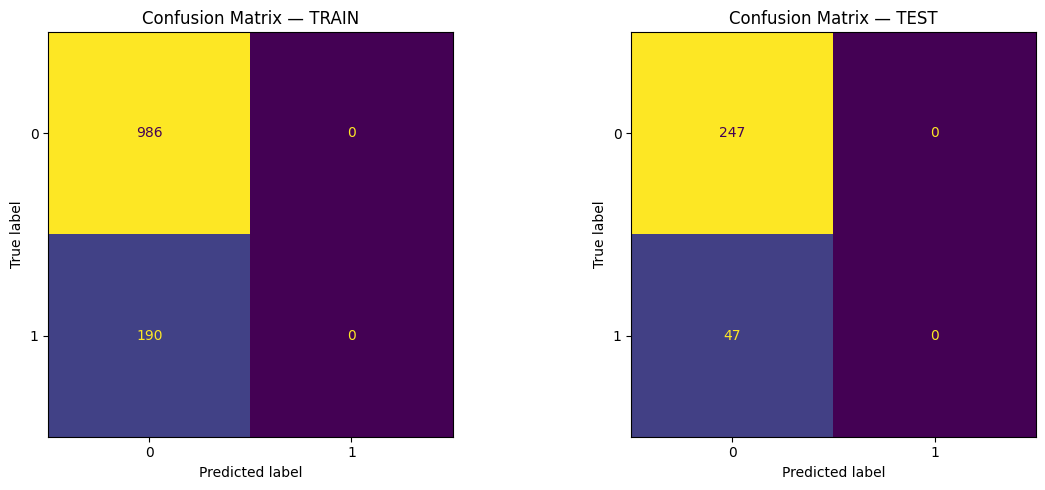

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(pipe, X_train, y_train, ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix — TRAIN")

ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix — TEST")

plt.tight_layout()
plt.show()

Sur la matrice de confusion :

* Dans les 2 cas, le modèle n'a pas prédit de 1.
Le DummyClassifier prédit toujours la classe majoritaire (0).

### Test sur le modèle linéaire : LogisticRegression

In [17]:
pipe = modelisation(
    model=LogisticRegression(random_state=42))

=== Résultats CV (train vs val) ===
precision         : train 0.783 ± 0.024 vs val 0.758 ± 0.068
recall            : train 0.405 ± 0.020 vs val 0.384 ± 0.092
f1                : train 0.533 ± 0.014 vs val 0.497 ± 0.076
average_precision : train 0.691 ± 0.012 vs val 0.618 ± 0.035
balanced_accuracy : train 0.692 ± 0.008 vs val 0.679 ± 0.040
 Classification Report — TRAIN
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       986
           1       0.79      0.39      0.53       190

    accuracy                           0.89      1176
   macro avg       0.84      0.69      0.73      1176
weighted avg       0.88      0.89      0.87      1176

Classification Report — TEST
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       247
           1       0.63      0.36      0.46        47

    accuracy                           0.86       294
   macro avg       0.76      0.66      0.69       294


Interprétation du modèle linéaire :

Validation croisée :

* Pas d'overfitting ici et on peut noter des écarts_types plutôt contrôlés. Le recall est bas, pas étonnant vu le jeu déséquilibré. On obtient une balanced_accuracy de 0.68 sur le test, une précision moyenne meilleure que le Dummy.

Classfication report :

* Accuracy : train 0.89 vs val 0.86. Le modèle classe correctement environ 86-89 % des salariés. L’écart train/test est quasi nul : pas d’overfitting. On peut noter également un meilleur score d'accuracy pour le modèle de régression logistique que notre étalon Dummy.

* Precision : train 0.79 vs test 0.63. Quand le modèle prédit “Oui” (départ), il a raison environ 6 fois sur 10. 

* Recall : train 0.39 vs test 0.36. Mais il ne détecte qu’environ 1 salarié sur 3 qui part réellement. Beaucoup de faux négatifs : le modèle loupe une majorité des départs.

#### Matrice de confusion du modèle linéaire

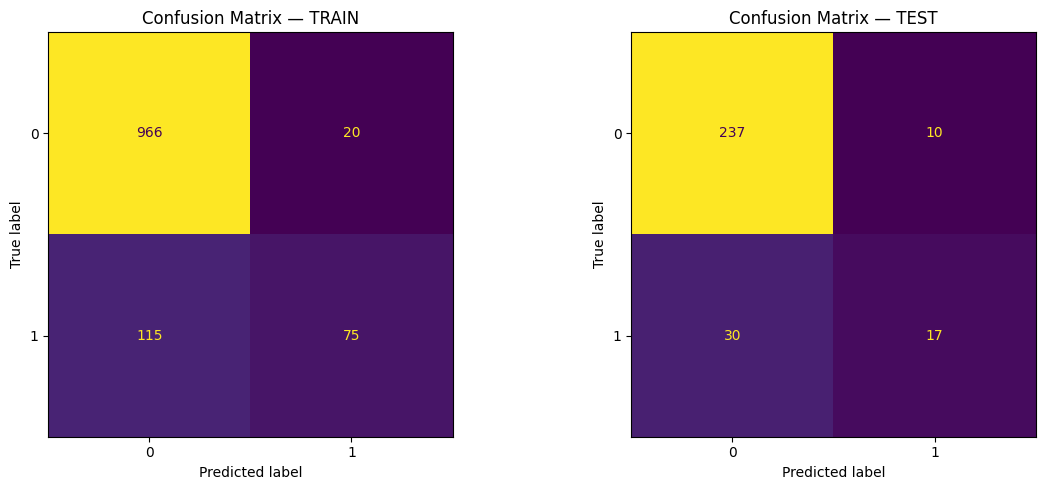

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(pipe, X_train, y_train, ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix — TRAIN")

ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix — TEST")

plt.tight_layout()
plt.show()

Sur la matrice de confusion :

* La classe 0 est bien gérée, presque 100%.
* La classe 1 est détectée mais encore faiblement (environ 40% de recall).
* Le modèle est conservateur : très peu de FP, mais beaucoup de FN.
* C’est mieux que le Dummy (qui n’avait aucun TP), mais ça reste déséquilibré.

### Nous décidons de tester deux modèles non linéaires :

* RandomForest
* CatBoost

#### RandomForest

In [19]:
pipe = modelisation(
    model=RandomForestClassifier(random_state=42))

=== Résultats CV (train vs val) ===
precision         : train 1.000 ± 0.000 vs val 0.907 ± 0.131
recall            : train 1.000 ± 0.000 vs val 0.136 ± 0.075
f1                : train 1.000 ± 0.000 vs val 0.225 ± 0.116
average_precision : train 1.000 ± 0.000 vs val 0.563 ± 0.002
balanced_accuracy : train 1.000 ± 0.000 vs val 0.566 ± 0.035
 Classification Report — TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       986
           1       1.00      1.00      1.00       190

    accuracy                           1.00      1176
   macro avg       1.00      1.00      1.00      1176
weighted avg       1.00      1.00      1.00      1176

Classification Report — TEST
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       247
           1       0.78      0.15      0.25        47

    accuracy                           0.86       294
   macro avg       0.82      0.57      0.59       294


Interprétation des résultats du RandomForestClassifier :

Sur la validation croisée :

* On voit bien l'overfit. Sans être étonné, nous avons un recall très bas dû au déséquilibre. On peut observer un écart-type plus "important" que les autres sur la précision.
* Par rapport au modèle linéaire notre balanced_accuracy est moins bonne, on chute à 0.57

Sur le classification report :
* Train = 1.00 partout : RandomForest overfit.
* Test (classe 1) : precision 0.78, recall 0.15 = le modèle rate presque tous les “1” (énormément de FN).
* Accuracy élevée en test (0.86) car la classe 0 domine : trompeuse.

#### Matrice de confusion de RandomForest

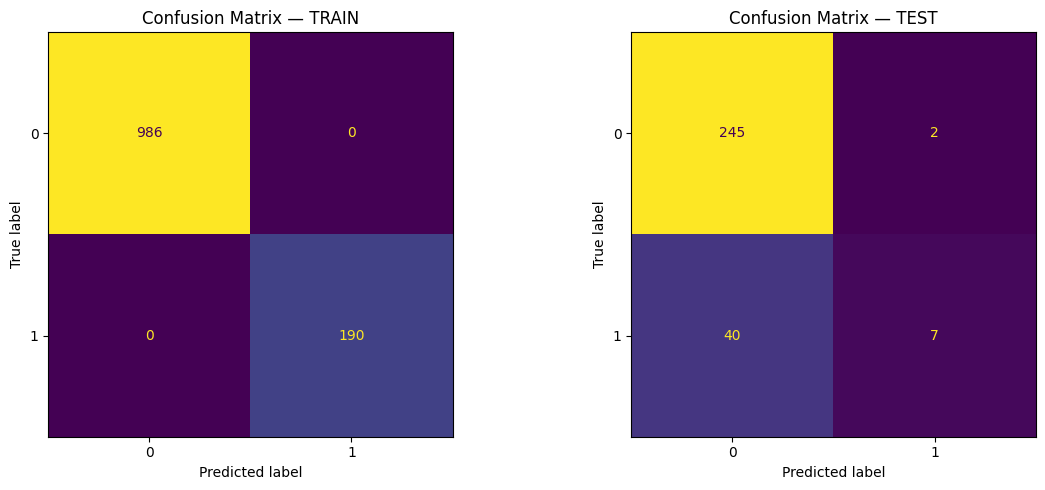

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(pipe, X_train, y_train, ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix — TRAIN")

ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix — TEST")

plt.tight_layout()
plt.show()

Interprétation de la matrice de confusion :
* Clairement de l'overfit sur le train
* On capte quelques classes 1 mais la plupart sont mal classées (en faux négatifs)

### CatBoost

In [21]:
pipe = modelisation(
    model=CatBoostClassifier(random_state=42, verbose=0))

=== Résultats CV (train vs val) ===
precision         : train 1.000 ± 0.000 vs val 0.888 ± 0.083
recall            : train 0.926 ± 0.015 vs val 0.289 ± 0.076
f1                : train 0.962 ± 0.008 vs val 0.426 ± 0.079
average_precision : train 0.999 ± 0.000 vs val 0.595 ± 0.002
balanced_accuracy : train 0.963 ± 0.007 vs val 0.640 ± 0.034
 Classification Report — TRAIN
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       986
           1       1.00      0.89      0.94       190

    accuracy                           0.98      1176
   macro avg       0.99      0.95      0.97      1176
weighted avg       0.98      0.98      0.98      1176

Classification Report — TEST
              precision    recall  f1-score   support

           0       0.87      0.99      0.92       247
           1       0.77      0.21      0.33        47

    accuracy                           0.86       294
   macro avg       0.82      0.60      0.63       294


Interprétation des résultats :

Sur la validation croisée :
* Le modèle étant également puissant, nous avons la présence d'un overfit entre le train et la validation. On note un recall plus faible que le modèle linéaire mais meilleur que le RandomForest.

Sur le classification report :
* Modèle faussé par le déséquilibre des données et mérite quelques paramètres pour ajuster les performances.

### Matrice de confusion pour CatBoost

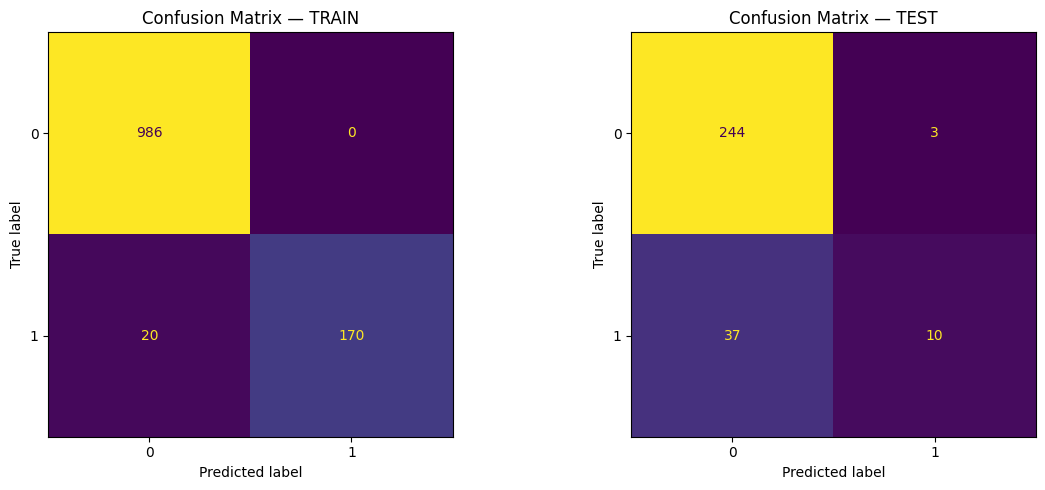

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(pipe, X_train, y_train, ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix — TRAIN")

ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix — TEST")

plt.tight_layout()
plt.show()

Sur la matrice de confusion :
* La classe 0 est bien gérée (presque 100% de recall).
* La classe 1 est détectée mais encore faiblement, on note bien le nombre de TP augmenté mais encore trop faible.
* Le modèle est conservateur : très peu de FP, mais beaucoup de FN.

## Petite conclusion

* On analyse facilement que les résultats sont tronqués par le déséquilibre de notre jeu de données. Les différents modèles captent essentiellement seulement les non-départs, ce qui n'est pas étonnant car nous avons une répartition de 84% pour les non-départs.
* On note la présence d'overfit pour les modèles de RandomForest et CatBoost
* Que ce soit pour le modèle de régression Logistique, de RandomForest/XGBoost et CatBoost, on voit que ces modèles ont un meilleur balanced_accuracy que le modèle étalon, Dummy. Ce qui est rassurant, les modèles font mieux qu'un modèle de base.
* Ici l'accuracy n'a pas de pertinence avec notre déséquilibre.

* Lors de la prochaine étape nous devrons effectuer des ajustements sur ce déséquilibre afin de capter le plus de Oui possible. Nous allons un peu jouer sur les paramètres afin d'améliorer nos modèles.
